# Stage 3

Importing required libraries:

In [ ]:
%pip install --quiet datasets seqeval

from datasets import load_dataset
from collections import defaultdict, Counter
from tqdm import trange, tqdm
from dataclasses import dataclass
import shutil
import pathlib
import os
import sys
import json
import itertools
import re
import multiprocessing
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, Subset, ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from torch.multiprocessing import Pool, set_start_method
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel, BertForTokenClassification
from seqeval.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import KFold

from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download, Repository, create_branch, create_repo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

shutil.copytree("/content/drive/MyDrive/nerc_test_task_model", "/content/", dirs_exist_ok=True)

Mounted at /content/drive


'/content/'

Make a repository for a future models.

In [ ]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) Y


In [ ]:
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/nerc-extraction"

HfApi().create_repo(repo_id=REPO_NAME, private=False, exist_ok=True)

print(f"Repository: '{REPO_NAME}'")

Repository: 'estnafinema0/nerc-extraction'


In [ ]:
API_URL = "https://llm.ispras.ru/api/chat/completions"
API_MODEL_URL = "https://llm.ispras.ru/api/models"
API_KEY = "YOUR_TOKEN"
# with open('./secrets') as file:
#     data: dict = json.load(file)
#     API_KEY = data.get('API_KEY', 'FAILED TO LOAD')

HIDDEN = 512
NER_TAGS = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
ADDITIONAL = {"[CLS]": 9, "[SEP]": 10, "X": 11}
NER_TAGS.update(ADDITIONAL)
TAGS_COUNT = len(NER_TAGS)
DATABASE_DIR = './data'
EMBEDDINGS_PATH = f'{DATABASE_DIR}/embeddings.txt'
CWD = '~/Рабочий стол/NERC_LLM_Ispras/data'
BERT_MODEL = 'bert-base-cased'
BATCH_SIZE = 32
EPOCHS = 5
INV_NER_TAGS = {v: k for k, v in NER_TAGS.items()}
PERCENTAGES = [.01, .02, .05, .1, .25, .5, 1.]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LOAD_FROM_REPO = False


## Initalizing Neural Network Model

Model will consist of:
    (1) *pre-trained BERT model* for word embeddings, which captures contextual information effectively.
    (2) *bidirectional LSTM (BiLSTM) layer* to process the sequence of embeddings and capture dependencies between words.
    (3) *linear layer* to map the LSTM outputs to the NER tags.

In [ ]:
class NERSmall(BertForTokenClassification, PyTorchModelHubMixin, repo_url=REPO_NAME, license="mit"):
    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, labels=None, label_masks=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)

        sequence_output = outputs[0]  # (b, MAX_LEN, 768)

        token_reprs = [embedding[mask] for mask, embedding in zip(label_masks, sequence_output)]
        token_reprs = pad_sequence(sequences=token_reprs, batch_first=True,
                                   padding_value=-1)  # (b, local_max_len, 768)
        sequence_output = self.dropout(token_reprs)
        logits = self.classifier(sequence_output)  # (b, local_max_len, num_labels)

        outputs = (logits,)
        if labels is not None:
            labels = [label[mask] for mask, label in zip(label_masks, labels)]
            labels = pad_sequence(labels, batch_first=True, padding_value=-1)  # (b, local_max_len)
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1, reduction='sum')
            mask = labels != -1
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            loss /= mask.float().sum()
            outputs = (loss,) + outputs + (labels,)

        return outputs  # (loss), scores, (hidden_states), (attentions)


## Parsing and Loading Data

We make `parse_dataformat` function to processe raw text data, splitting it into sentences and their corresponding NER tags. We make it handle empty lines and document separators. It organizes the data into a list of InputExample objects.

In [ ]:
# To organize the data, we define a simple data structure `InputExample`:

@dataclass
class InputExample:
    guid: str
    text: str
    ner_tag: list[str]

def parse_dataformat(base_data: str, set_type: str) -> list[InputExample]:
    data = []
    sentence = []
    ner_tags = []
    for line in base_data.splitlines():
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                data.append((sentence, ner_tags))
                sentence = []
                ner_tags = []
            continue
        splits = line.split(' ')
        sentence.append(splits[0])
        ner_tags.append(splits[-1])

    if len(sentence) > 0:
        data.append((sentence, ner_tags))
        sentence = []
        ner_tags = []

    return [InputExample(f'{set_type}-{i}', ' '.join(sentence), ner_tag) for i, (sentence, ner_tag) in enumerate(data)]

def load_example(filepath, name) -> tuple[list[InputExample], list[InputExample], list[InputExample]]:
    with open(filepath) as file:
        file_data = file.read()
    return parse_dataformat(file_data, name)

def load_examples(data_dir) -> tuple[list[InputExample], list[InputExample], list[InputExample]]:
    return (load_example(pathlib.Path.joinpath(pathlib.Path(data_dir), 'test.txt'), 'test'),
            load_example(pathlib.Path.joinpath(pathlib.Path(data_dir), 'train.txt'), 'train'),
            load_example(pathlib.Path.joinpath(pathlib.Path(data_dir), 'valid.txt'), 'valid'))

## Custom Dataset

Now we need to create `NERDataSet` class that prepares the data for training. It tokenizes the input text, maps NER tags to their corresponding IDs, and pads sequences to a fixed length. The __getitem__ method processes each example by adding special tokens [CLS] and [SEP], tokenizing the text, and creating attention masks and sentence IDs. The method returns tensors for input IDs, NER tag IDs, attention masks, sentence IDs, and tag masks, which are used by the model during training.

## Training Environment

We are using BERT Tokenizer from `from_pretrained`.

The dataset is loaded into training, validation, and test sets using the load_examples function. DataLoader objects are created for each dataset, enabling efficient batching and shuffling of the data during training and evaluation.

In [ ]:
class NERDataSet(Dataset):
    def __init__(self, data: list[InputExample], tokenizer: BertTokenizer, ner_tag_map: dict[str, int], max_len: int = 128):
        self._max_len = max_len
        self._ner_tag_map = ner_tag_map
        self._data = data
        self._tokenizer = tokenizer

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx: int):
        input_example = self._data[idx]

        text = input_example.text
        ner_tags = input_example.ner_tag
        word_tokens = ['[CLS]']
        ner_tag_list = ['[CLS]']
        ner_tag_mask = [0]  # value in {0,1} -- 0 signifies invalid token

        input_ids = [self._tokenizer.convert_tokens_to_ids('[CLS]')]
        ner_tag_ids = [self._ner_tag_map['[CLS]']]

        for word, ner_tag in zip(text.split(), ner_tags):
            tokenized_word = self._tokenizer.tokenize(word)

            word_tokens.extend(tokenized_word)
            assert len(tokenized_word) > 0
            input_ids.extend(map(self._tokenizer.convert_tokens_to_ids, tokenized_word))

            ner_tag_list.append(ner_tag)
            ner_tag_ids.append(self._ner_tag_map[ner_tag])
            ner_tag_mask.append(1)
            # len(tokenized_word) > 1 only if it splits word in between, in which case
            # the first token gets assigned NER tag and the remaining ones get assigned
            # X
            ner_tag_list.extend(itertools.repeat('X', len(tokenized_word) - 1))
            ner_tag_ids.extend(itertools.repeat(self._ner_tag_map['X'], len(tokenized_word) - 1))
            ner_tag_mask.extend(itertools.repeat(0, len(tokenized_word) - 1))

        assert len(word_tokens) == len(ner_tag_list) == len(input_ids) == len(ner_tag_ids) == len(ner_tag_mask)

        if len(word_tokens) >= self._max_len:
            word_tokens = word_tokens[:(self._max_len - 1)]
            ner_tag_list = ner_tag_list[:(self._max_len - 1)]
            input_ids = input_ids[:(self._max_len - 1)]
            ner_tag_ids = ner_tag_ids[:(self._max_len - 1)]
            ner_tag_mask = ner_tag_mask[:(self._max_len - 1)]

        assert len(word_tokens) < self._max_len, len(word_tokens)

        word_tokens.append('[SEP]')
        ner_tag_list.append('[SEP]')
        input_ids.append(self._tokenizer.convert_tokens_to_ids('[SEP]'))
        ner_tag_ids.append(self._ner_tag_map['[SEP]'])
        ner_tag_mask.append(0)

        assert len(word_tokens) == len(ner_tag_list) == len(input_ids) == len(ner_tag_ids) == len(ner_tag_mask)

        sentence_id = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)

        left = self._max_len - len(input_ids)
        input_ids.extend(itertools.repeat(0, left))
        ner_tag_ids.extend(itertools.repeat(self._ner_tag_map['X'], left))
        attention_mask.extend(itertools.repeat(0, left))
        sentence_id.extend(itertools.repeat(0, left))
        ner_tag_mask.extend(itertools.repeat(0, left))


        assert len(word_tokens) == len(ner_tag_list)
        assert len(input_ids) == len(ner_tag_ids) == len(attention_mask) == len(sentence_id) == len(
            ner_tag_mask) == self._max_len, len(input_ids)
        return torch.LongTensor(input_ids), torch.LongTensor(ner_tag_ids), torch.LongTensor(
            attention_mask), torch.LongTensor(sentence_id), torch.BoolTensor(ner_tag_mask)

    @staticmethod
    def collate_fn(batch):
        return {
            'input_ids': torch.stack([x['input_ids'] for x in batch]),
            'attention_mask': torch.tensor([x['attention_mask'] for x in batch])
        }

## Training Environment

We are using BERT Tokenizer from `from_pretrained`.

The dataset is loaded into training, validation, and test sets using the load_examples function. DataLoader objects are created for each dataset, enabling efficient batching and shuffling of the data during training and evaluation.

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
test, train, valid = load_examples(DATABASE_DIR)
test = NERDataSet(test, tokenizer, NER_TAGS)
train = NERDataSet(train, tokenizer, NER_TAGS)
valid = NERDataSet(valid, tokenizer, NER_TAGS)
train_iter = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
eval_iter = DataLoader(dataset=valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_iter = DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

We will use *CrossEntropy* Loss Function and Stochastic Gradient Descent with a learning rate of 0.001 and momentum of 0.9 to accelerate convergence.

In [ ]:
def train_model(model, train_iter, optimizer, epochs=EPOCHS):
  model = model.train()
  for epoch in trange(epochs, desc='Epoch'):
      running_loss = 0.0
      tr_loss = 0
      nb_tr_steps = 0
      for batch in tqdm(train_iter):
          # input_ids, labels, input_mask, token_type_ids, label_masks = batch
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_labels, b_input_mask, b_token_type_ids, b_label_masks = batch
          optimizer.zero_grad()

          loss, logits, labels = model(b_input_ids, token_type_ids=b_token_type_ids,
                                          attention_mask=b_input_mask, labels=b_labels,
                                          label_masks=b_label_masks)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          # track train loss
          tr_loss += loss.item()
          nb_tr_steps += 1
          # update parameters
          optimizer.step()
          model.zero_grad()
          # print train loss per epoch
      print(f"Train loss: {tr_loss / nb_tr_steps}")

  print('Finished Training')

### Evaluating Primary Model

## Generation of syntetic dataset

Now we need a function to retrieve model answers and generate a dataset to train our NER model.

In [ ]:
with open('prompts-latest.json') as file:
    data = json.load(file)

pattern = re.compile(r"""Tokens: '(`.*`(, )?)+'""") #  '`([\w\d.,';":!?\[\]\(\)]+`(, )?)+'

INV_NER_TAGS = {v: k for k, v in NER_TAGS.items()}

keys = list(data.keys())
tokenss = [(list(map(lambda x: x[1:-1], next(re.finditer(pattern, str(key))).group(1).split(', '))),
            list(map(lambda k: INV_NER_TAGS.get(k, None), value['predicted'])))
           for key, value in data.items()]

tokenss = [(l, t) for l, t in tokenss if all(k is not None for k in t)]

def gen_examples(examples):
    nl = '\n'
    return f"""{f'{nl}{nl}'.join(f'{nl}'.join(f'{token} {tag}' for token, tag in zip(*tokens)) for tokens in examples)}"""

with open('data/llm.txt', 'w') as file:
    print(gen_examples(tokenss), file=file)


In [ ]:
llm_pure = load_example('data/llm.txt', "llm_pure")
llm_pure = NERDataSet(llm_pure, tokenizer, NER_TAGS)
llm_pure_iter = DataLoader(dataset=llm_pure, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

To download llm pure model from HuggingFace:



In [ ]:
model_llm_pure = NERSmall.from_pretrained("estnafinema0/nerc-extraction", revision="llm_pure_model").to(device)

model.safetensors:  63%|######3   | 273M/431M [00:00<?, ?B/s]

Let's evaluate our pure llm model:

## Comparative analysis

In [ ]:
# primary_metrics = evaluate_entity_level(model_primary, test_iter, optimizer_primary)
# llm_pure_metrics = evaluate(model_llm_pure, test_iter, optimizer_llm_pure)

## Results

There is a clear positive correlation between the percentage of high-quality data in the training set and the model’s performance on the named entity recognition task. Below is a detailed breakdown of the key observations based on the provided validation loss, seqeval accuracy, F1-Score, and classification reports.

We see that the validation loss is highest when only a minimal fraction of high-quality data is used. As the proportion of high-quality data increases, the validation loss steadily decreases.


### Classification Reports
A closer examination of the classification reports reveals that:
- *PER (Person)* often achieves relatively high precision and recall, reflecting the model’s strength in recognizing well-represented classes.
- *LOC (Location)* and *ORG (Organization)* generally improve as the quality and quantity of training data increase, though their performance may lag behind PER if fewer high-quality examples are available.

### Budget Analysis
The *Validation Loss Improvement vs. Budget* and *Seqeval Accuracy Improvement vs. Budget* plots highlight that, while adding high-quality data initially offers substantial gains, the marginal improvement tapers off once the model has sufficient representative examples. This pattern underlines the necessity of strategically allocating annotation resources to maximize the benefit of each additional high-quality example.

### Overall Conclusion
In summary, augmenting the training set with high-quality data significantly boosts the model’s performance on named entity recognition tasks. Early additions of well-annotated examples yield the most pronounced gains in validation loss reduction and seqeval accuracy improvement. As the volume of high-quality data grows, improvements become more incremental.

# Active learning

## Overview

In this section, we implement an active learning framework for Named Entity Recognition (NER). Our goal is to iteratively improve a base model (already fine-tuned on a low-quality dataset plus an initial 12% of expert examples, i.e. our `model_init_12`) by selecting the most uncertain examples from a large expert dataset and using them to further fine-tune the model. Each intermediate model is saved in a separate branch on Hugging Face, and we record performance metrics (entity-level F1-score, seqeval accuracy, and validation loss) to analyze the improvement as we add more expert examples.

## 1. Entity-Level Evaluation Module

It is a improved metric to evaluate the performance of the model at the entity level, which is crucial for NER. A correct prediction requires that the entire entity (with proper boundaries and correct labels) is recognized correctly.

  1. Prediction Collection: The function processes each batch from the evaluation DataLoader and, for each sentence, collects predicted labels and true labels in a list-of-lists format.
  2. Metric Calculation: It then computes entity-level metrics using the `seqeval` library:
     - Seqeval Accuracy: The overall accuracy calculated on an entity basis.
     - F1-Score: The harmonic mean of precision and recall at the entity level.
     - Classification Report: Detailed precision, recall, and F1 for each entity type.

## 2. Uncertainty Estimation Module

The purpose is to assess the uncertainty of each sentence (example) by computing the average entropy of its tokens. The idea is that a high average entropy indicates the model is less confident in its predictions for that sentence.


We will assess the uncertainty of a sentence using the average entropy of its tokens. For each example (sentence) returned by the `NERDataSet` class, we:

1. Pass it through the model in `eval` mode (with gradients disabled);
2. Retrieve the logits and apply softmax to obtain a probability distribution over labels for each token;
3. For each token (only the “valid” ones, where `ner_tag_mask == 1`), compute the entropy:
   $$
   H(token) = - \sum_{y} P(y\mid token)\log P(y\mid token)
   $$
4. The average entropy across all valid tokens serves as the uncertainty measure for the sentence.


## 3. Preliminary Threshold Experiment with K-Fold Cross-Validation

 Before starting the iterative active learning loop, we run a preliminary experiment to determine the minimal volume of expert examples that yield a significant improvement over the baseline (the model already trained on 12% expert data). Using k-fold cross-validation helps to smooth out random fluctuations and outliers.

  1. For each percentage value (e.g., 1%, 2%, 3%, 5%, 7%, 10%, 12%, 15%, 20%) we determine the number of expert examples to add (using the size of the cheap dataset as a reference).
  2. K-Fold Splitting: The expert dataset is split into *k* folds (we use 5-fold cross-validation).
  3. Fine-Tuning per Fold: For each fold, a subset of expert examples is selected, combined with the cheap dataset, and the model is fine-tuned for a few epochs.
  4. Metric Averaging: We compute and average the evaluation metrics (F1, seqeval accuracy, and validation loss) over all folds.
  5. Graphing: We then build a graph plotting F1-score versus the number of added expert examples to identify the point where improvements saturate.

## 4. Active Learning Loop

  The core iterative loop that implements active learning. Starting from a base model (model_init_12), it repeatedly:
  - Computes uncertainty for remaining expert examples,
  - Selects the top uncertain examples (batch size is controlled by `batch_to_add`, set here to 10),
  - Fine-tunes the model on the combined dataset (initial training data plus newly added expert examples),
  - Saves the intermediate model in a separate branch on Hugging Face,
  - And stops when the improvement (delta F1-score) is below a set threshold (after a minimum number of iterations).


Since model_init_12 is already trained on 12% expert data, the active learning loop should start from an initial training dataset that equals that combined dataset. This ensures that the baseline performance is consistent with model_init_12, and that subsequent improvements are measured relative to that baseline.

To note(!):
```
def active_learning_loop(model, cheap_dataset, expert_dataset, eval_iter,
                         initial_epochs=5, fine_tune_epochs=2, batch_to_add=5,
                         improvement_threshold=0.00005, max_iterations=15,
                         use_initial_training=False, min_iterations = 10)`:  
```   
It now takes an additional parameter `initial_train_dataset`, which is the union of the cheap dataset and the initial 12% expert examples.  
It iterates up to `max_iterations`, and each iteration saves the updated model in a dedicated branch (named based on iteration and total added examples).  
The loop records metrics at each step in a history list.

In [ ]:
len(llm_pure)

In [ ]:
def evaluate_entity_level(model, eval_iter, optimizer=None):
    """
    Evaluates the model. Saves predictions and true labels per sentence.
    Expected output: a tuple (eval_loss, seqeval_accuracy, f1_score, classification_report_dict)
    All metrics are computed at the entity level.
    """
    model.eval()
    eval_loss = 0.0
    nb_eval_steps = 0

    all_pred_sentences = []  # each element is a list of predicted labels for a sentence
    all_true_sentences = []

    special_tags = {"[CLS]", "[SEP]"}

    for batch in tqdm(eval_iter, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels, b_input_mask, b_token_type_ids, b_label_masks = batch

        with torch.no_grad():
            tmp_eval_loss, logits, reduced_labels = model(b_input_ids,
                                                           token_type_ids=b_token_type_ids,
                                                           attention_mask=b_input_mask,
                                                           labels=b_labels,
                                                           label_masks=b_label_masks)
        # logits: (batch_size, local_max_len, num_labels)
        # reduced_labels: (batch_size, local_max_len) with -1 for invalid tokens

        preds = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        preds = preds.detach().cpu().numpy()
        true_labels = reduced_labels.detach().cpu().numpy()

        for pred_seq, true_seq, mask in zip(preds, true_labels, b_label_masks.detach().cpu().numpy()):
            pred_sentence = []
            true_sentence = []
            for p, t, m in zip(pred_seq, true_seq, mask):
                if m:  # valid token based on mask
                    if t == -1:  # rto skip tokens with true label -1
                        continue
                    true_tag = INV_NER_TAGS[t]
                    pred_tag = INV_NER_TAGS[p]

                    #==============
                    if true_tag in special_tags or pred_tag in special_tags:
                        continue
                    pred_sentence.append(pred_tag)
                    true_sentence.append(true_tag)
                    #==============
            if len(pred_sentence) > 0:
                all_pred_sentences.append(pred_sentence)
                all_true_sentences.append(true_sentence)

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
    eval_loss /= nb_eval_steps

    seq_eval_accuracy = accuracy_score(all_true_sentences, all_pred_sentences)
    f1 = f1_score(all_true_sentences, all_pred_sentences)
    class_report = classification_report(all_true_sentences, all_pred_sentences)

    print(f"Validation loss: {eval_loss}")
    print(f"Seqeval accuracy: {seq_eval_accuracy}")
    print(f"F1-Score: {f1}")
    print("Classification report:")
    print(class_report)

    return eval_loss, seq_eval_accuracy, f1, classification_report(all_true_sentences, all_pred_sentences, output_dict=True)

def compute_sentence_uncertainty(model, dataset):
    """
    Computes an uncertainty measure for each example in the dataset.
    The uncertainty is defined as the average entropy over valid tokens,
    calculated from model outputs after applying label masks.

    Arguments:
      - model: a trained NER model (in eval mode).
      - dataset: an instance of NERDataSet (expert dataset).

    Returns:
      - uncertainties: list (of length len(dataset)) of uncertainty values (average entropy per example).
      - indices: list of indices (used for selecting top uncertain examples).
    """
    model.eval()
    uncertainties = []
    indices = []

    data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    idx_counter = 0
    for batch in tqdm(data_loader, desc="Computing uncertainty"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels, b_input_mask, b_token_type_ids, b_label_masks = batch

        with torch.no_grad():

            _, logits, _ = model(b_input_ids, token_type_ids=b_token_type_ids,
                                 attention_mask=b_input_mask, labels=b_labels,
                                 label_masks=b_label_masks) # Obtain logits for valid tokens inside the model (see model’s forward method)
        # logits shape: (batch_size, local_max_len, num_labels)
        # Compute softmax and entropy across the label dimension
        probs = F.softmax(logits, dim=2)  # (batch_size, seq_len, num_labels)
        # Entropy: H = -sum(P * log(P)) for each token, result shape: (batch_size, seq_len)
        entropies = -torch.sum(probs * torch.log(probs + 1e-10), dim=2)
        # print(tuple(zip(entropies, logits))[0])

        # For each example in the batch, average entropy across tokens
        # (logits are already filtered to valid tokens in the model)
        for i in range(entropies.size(0)):
            avg_entropy = entropies[i].mean().item()
            uncertainties.append(avg_entropy)
            indices.append(idx_counter)
            idx_counter += 1

    return uncertainties, indices


In [ ]:
indices = torch.arange(4*BATCH_SIZE)
test_10 = Subset(test, indices)
test_iter_10 = DataLoader(dataset=test_10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


uncertainties, indices = compute_sentence_uncertainty(model_llm_pure, test_10)

In [ ]:
def preliminary_threshold_experiment_kfold(base_model, cheap_dataset, expert_dataset, eval_iter,
                                           percentages=[0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.12, 0.15, 0.20],
                                           fine_tune_epochs=3, k=5):
    """
    Performs a preliminary threshold experiment using k-fold (e.g., 5-fold) cross-validation
    on the expert dataset to determine the minimal volume of expert examples needed for improvement.

    For each specified percentage of the cheap_dataset size:
      - The expert dataset is split into k folds.
      - From each fold, a number of examples equal to percentage * len(cheap_dataset) is selected.
      - Each fold is combined with the cheap_dataset.
      - The model is fine-tuned on the combined dataset for fine_tune_epochs epochs.
      - Metrics are computed (F1-score, seqeval accuracy, validation loss).
      - Results are averaged across all folds.

    Returns:
      - results: a list of tuples (percentage, num_expert_added, avg_f1, avg_seqeval_acc, avg_val_loss)
    """
    results = []
    cheap_size = len(cheap_dataset)
    num_to_add_base = lambda p: int(cheap_size * p)  # number of expert examples for the given percentage

    expert_indices = list(range(len(expert_dataset)))
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # cross-validation
    for p in percentages:
        num_to_add = num_to_add_base(p)
        print(f"\nExperiment with adding {p*100:.0f}% expert examples ({num_to_add} sentences per fold)")

        fold_f1 = []
        fold_seqeval = []
        fold_loss = []

        # Split expert in k folds
        for train_index, test_index in kf.split(expert_indices):
            selected_indices = list(train_index[:num_to_add])
            if len(selected_indices) == 0: # If the fold contains fewer, take all available examples.
                continue

            expert_subset_fold = torch.utils.data.Subset(expert_dataset, selected_indices)

            combined_dataset = torch.utils.data.ConcatDataset([cheap_dataset, expert_subset_fold])
            combined_iter = DataLoader(dataset=combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

            model_clone = copy.deepcopy(base_model).to(device)
            optimizer = optim.SGD(model_clone.parameters(), lr=0.001, momentum=0.9)

            print(f"Fine tuning on fold (adding {len(selected_indices)} expert sentences)...")
            train_model(model_clone, combined_iter, optimizer, epochs=fine_tune_epochs)

            # Evaluate the fine-tuned
            metrics = evaluate_entity_level(model_clone, eval_iter)
            fold_f1.append(metrics[2])
            fold_seqeval.append(metrics[1])
            fold_loss.append(metrics[0])

        avg_f1 = np.mean(fold_f1) if fold_f1 else None
        avg_seqeval = np.mean(fold_seqeval) if fold_seqeval else None
        avg_loss = np.mean(fold_loss) if fold_loss else None
        print(f"Average for {p*100:.0f}%: F1 = {avg_f1:.4f}, Seqeval Accuracy = {avg_seqeval:.4f}, Loss = {avg_loss:.4f}")
        results.append((p, num_to_add, avg_f1, avg_seqeval, avg_loss))

    return results


In [ ]:
# results_threshold_kfold = preliminary_threshold_experiment_kfold(model_llm_pure, llm_pure, train, eval_iter)

In [ ]:
def plot_threshold_experiment(results):
    """
    Plots the F1-score as a function of the number of added expert examples.
    Argument `results` is a list of tuples: (percentage, num_expert_added, f1_score, seqeval_accuracy, validation_loss)
    """
    num_expert = [r[1] for r in results]
    f1_scores = [r[2] for r in results]

    plt.figure(figsize=(8, 5))
    plt.plot(num_expert, f1_scores, marker='o', linestyle='-', color='blue')
    plt.title("F1-score vs. Number of Added Expert Examples")
    plt.xlabel("Number of Expert Examples Added")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.show()

In [ ]:
# results_threshold_kfold


In the preliminary threshold experiment, we used 5-fold cross-validation to smooth out potential fluctuations. Below is the resulting F1-score curve as a function of the number of expert examples added. Around **240 expert examples** (which is roughly 12% of the expert dataset), the F1-score appears to reach a plateau, indicating the saturation point for further improvements.

![alt text](images/image-1.png)


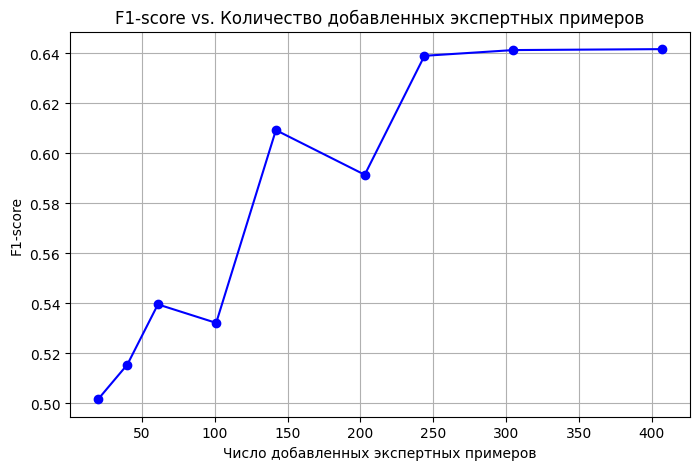

In [ ]:
# plot_threshold_experiment(results_threshold_kfold)

In [ ]:
# The low-quality dataset has already been loaded and is named llm_pure (≈2000 sentences)
# The expert dataset (with high-quality annotations) has been loaded as train (≈14,000 sentences)
# The model trained on the low-quality dataset is named model_llm_pure
# eval_iter is a DataLoader for the validation or test set

num_to_add = int(len(llm_pure) * 0.12)
print(f"Number of expert examples to be added: {num_to_add}")

expert_subset = Subset(train, list(range(num_to_add)))

combined_dataset = ConcatDataset([llm_pure, expert_subset])
combined_loader = DataLoader(dataset=combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"The combined training dataset contains {len(combined_dataset)} examples.")

torch.save(combined_dataset, "data/combined_dataset.pth")
print("Combined dataset saved to combined_dataset.pth")

model_init_12 = copy.deepcopy(model_llm_pure).to(device)
optimizer = optim.SGD(model_init_12.parameters(), lr=0.001, momentum=0.9)

print("Starting model fine-tuning on the combined dataset (12% expert examples)...")
# Fine-tuning is performed for 5 epochs.
train_model(model_init_12, combined_loader, optimizer, epochs=5)

print("Evaluating the model after fine-tuning:")
eval_metrics = evaluate_entity_level(model_init_12, eval_iter)
print("Metrics:", eval_metrics)


In [ ]:
loaded_combined_dataset = torch.load("data/combined_dataset.pth", weights_only=False)
print(f"Loaded combined dataset with {len(loaded_combined_dataset)} examples.")

Loaded combined dataset with 2281 examples.


In [ ]:
REPO_NAME_KFOLD = "estnafinema0/active-learning-nerc-models-kfold"
branch_name_init_12 = "model_percentage12"

create_repo(repo_id=REPO_NAME_KFOLD, exist_ok=True)
create_branch(repo_id=REPO_NAME_KFOLD, branch=branch_name_init_12, exist_ok=True)

model_init_12.push_to_hub(REPO_NAME_KFOLD, revision=branch_name_init_12)
print(f"The model fine-tuned on 12% of expert data has been successfully uploaded to the '{REPO_NAME_KFOLD}' repository in the '{branch_name_init_12}' branch.")

No files have been modified since last commit. Skipping to prevent empty commit.


The model fine-tuned on 12% of expert data has been successfully uploaded to the 'estnafinema0/active-learning-nerc-models-kfold' repository in the 'model_percentage12' branch.


In [ ]:
REPO_NAME_KFOLD = "estnafinema0/active-learning-nerc-models-kfold"
branch_name_init_12 = "model_percentage12"

model_init_12 = NERSmall.from_pretrained(REPO_NAME_KFOLD, revision=branch_name_init_12).to(device)

Below is a comparison of the initial evaluation metrics for two models. The first model, **model_llm_pure**, was trained solely on the low-quality (cheap) dataset, while the second model, **model_init_12**, was fine-tuned on the low-quality dataset combined with an additional 12% of expert examples. As shown in the table, model_init_12 achieves a lower validation loss, higher seqeval accuracy, and a significantly improved F1-Score compared to model_llm_pure.

| Model           | Validation Loss | Seqeval Accuracy | F1-Score |
|-----------------|-----------------|------------------|----------|
| model_llm_pure  | 0.53443         | 0.85185          | 0.47493  |
| model_init_12   | 0.33402         | 0.93084          | 0.65344  |


In [ ]:
eval_loss, acc, f1, rep = evaluate_entity_level(model_llm_pure, eval_iter)
eval_loss, acc, f1, rep = evaluate_entity_level(model_init_12, eval_iter)

Evaluating: 100%|██████████| 102/102 [00:22<00:00,  4.62it/s]


Validation loss: 0.5344288140973624
Seqeval accuracy: 0.8518499669194362
F1-Score: 0.4749313186813186
Classification report:
              precision    recall  f1-score   support

         LOC       0.35      0.80      0.49      1089
        MISC       0.04      0.10      0.06       693
         ORG       0.29      0.53      0.37       824
         PER       0.76      0.96      0.85      1455

   micro avg       0.36      0.68      0.47      4061
   macro avg       0.36      0.60      0.44      4061
weighted avg       0.43      0.68      0.52      4061



Evaluating: 100%|██████████| 102/102 [00:22<00:00,  4.45it/s]


Validation loss: 0.3340221427234949
Seqeval accuracy: 0.9308361748689501
F1-Score: 0.6534444561662623
Classification report:
              precision    recall  f1-score   support

         LOC       0.56      0.85      0.68      1089
        MISC       0.28      0.39      0.33       693
         ORG       0.44      0.60      0.50       824
         PER       0.83      0.97      0.89      1455

   micro avg       0.57      0.76      0.65      4061
   macro avg       0.53      0.70      0.60      4061
weighted avg       0.59      0.76      0.66      4061



In [ ]:
# uncertainties_, indices_ = compute_sentence_uncertainty(model_init_12, train)

Computing uncertainty: 100%|██████████| 439/439 [00:24<00:00, 17.93it/s]


In [ ]:
REPO_NAME_KFOLD = "estnafinema0/active-learning-nerc-models-kfold"

def active_learning_loop(model, cheap_dataset, expert_dataset, eval_iter,
                         initial_epochs=5, fine_tune_epochs=2, batch_to_add=5,
                         improvement_threshold=0.005, max_iterations=15,
                         use_initial_training=False, min_iterations=10):
    """
    Iterative active learning loop with intermediate model checkpoints pushed to Hugging Face.

    Arguments:
      - model: base model, e.g., model_init_12 (if already fine-tuned on the cheap dataset)
      - cheap_dataset: low-quality dataset (e.g., 1000 sentences) + 12% expert examples
      - expert_dataset: expert-quality dataset (e.g., 14000 sentences)
      - eval_iter: DataLoader for the validation or test set
      - initial_epochs: number of epochs for initial training (on the cheap dataset)
      - fine_tune_epochs: number of epochs for fine-tuning on the combined dataset
      - batch_to_add: number of expert examples to add per iteration
      - improvement_threshold: F1-score improvement threshold below which active learning stops
      - max_iterations: maximum number of active learning iterations
      - use_initial_training: if True, the model is initially trained on the cheap dataset;
          if False, assumes the model is already pre-trained (e.g., model_init_12)

    Returns:
      - history: a list of tuples (total_added, f1_score, seqeval_accuracy, validation_loss)
    """
    print("Using pre-trained model (model_init_12) as starting point for active learning.")

    # Initial model evaluation (entity-level)
    print("Initial evaluation:")
    base_metrics = evaluate_entity_level(model, eval_iter)
    base_f1 = base_metrics[2]
    total_added = 0
    history = []

    current_train_dataset = cheap_dataset
    # Indices of all expert examples
    remaining_expert = list(range(len(expert_dataset)))

    for it in range(max_iterations):
        print(f"\nActive Learning Iteration {it+1}:")
        # Create a Subset of the remaining expert examples
        expert_subset = torch.utils.data.Subset(expert_dataset, remaining_expert)
        expert_loader = DataLoader(expert_subset, batch_size=32, shuffle=False, num_workers=2)

        uncertainties, indices = compute_sentence_uncertainty(model, expert_subset)
        global_indices = [remaining_expert[i] for i in indices]

        # Sort (global index, uncertainty) pairs in descending order of uncertainty
        sorted_pairs = sorted(zip(global_indices, uncertainties), key=lambda x: x[1], reverse=True)

        if len(sorted_pairs) < batch_to_add:
            print("Not enough remaining expert examples. Stopping iteration.")
            break

        # Top-N most uncertain examples
        selected = [pair[0] for pair in sorted_pairs[:batch_to_add]]
        print(f"Selected expert indices: {selected}")

        # Update the list of remaining expert examples
        remaining_expert = [idx for idx in remaining_expert if idx not in selected]
        total_added += len(selected)

        new_expert_subset = torch.utils.data.Subset(expert_dataset, selected)

        current_train_dataset = ConcatDataset([current_train_dataset, new_expert_subset])
        print(f"Total training examples now: {len(current_train_dataset)}")

        current_train_iter = DataLoader(dataset=current_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

        # Fine-tune the model on the updated dataset
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        print("Fine tuning on updated training set:")
        train_model(model, current_train_iter, optimizer, epochs=fine_tune_epochs)

        branch_name = f"active_iter_{it+1}_added_{total_added}"
        model.push_to_hub(REPO_NAME_KFOLD, revision=branch_name)

        print("Evaluation after fine tuning:")
        metrics = evaluate_entity_level(model, eval_iter)
        current_f1 = metrics[2]

        history.append((total_added, current_f1, metrics[1], metrics[0]))

        # If F1 improvement is below threshold and the minimum iteration count is met, stop
        if (current_f1 - base_f1) < improvement_threshold and it >= min_iterations:
            print("Improvement threshold reached. Stopping active learning.")
            break
        else:
            base_f1 = current_f1

    return history


In [ ]:
# Passed combined_dataset
active_history = active_learning_loop(model_init_12, combined_dataset, train, eval_iter, fine_tune_epochs=2, batch_to_add=50)

In [ ]:
def plot_active_learning_history(history):
    """
    Plots the F1-score as a function of the total number of added expert examples.
    history: list of tuples (total_added, f1_score, seqeval_accuracy, validation_loss)
    """
    total_added = [item[0] for item in history]
    f1_scores = [item[1] for item in history]

    plt.figure(figsize=(8, 5))
    plt.plot(total_added, f1_scores, marker='o', linestyle='-', color='blue')
    plt.title("F1-score vs. Number of Added Expert Examples")
    plt.xlabel("Number of Expert Examples Added")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.show()

In [ ]:
plot_active_learning_history(active_history)

NameError: name 'active_history' is not defined

In [ ]:
REPO_NAME_KFOLD = "estnafinema0/active-learning-nerc-models-kfold"

def active_learning_loop_no_overfit(model, cheap_dataset, expert_dataset, eval_iter,
                         initial_epochs=5, fine_tune_epochs=2, batch_to_add=5,
                         improvement_threshold=0.005, max_iterations=15,
                         use_initial_training=False, min_iterations=10):
    """
    Iterative active learning loop with intermediate model checkpoints pushed to Hugging Face.

    Arguments:
      - model: base model, e.g., model_init_12 (if already fine-tuned on the cheap dataset)
      - cheap_dataset: low-quality dataset (e.g., 1000 sentences) + 12% expert examples
      - expert_dataset: expert-quality dataset (e.g., 14000 sentences)
      - eval_iter: DataLoader for the validation or test set
      - initial_epochs: number of epochs for initial training (on the cheap dataset)
      - fine_tune_epochs: number of epochs for fine-tuning on the combined dataset
      - batch_to_add: number of expert examples to add per iteration
      - improvement_threshold: F1-score improvement threshold below which active learning stops
      - max_iterations: maximum number of active learning iterations
      - use_initial_training: if True, the model is initially trained on the cheap dataset;
          if False, assumes the model is already pre-trained (e.g., model_init_12)

    Returns:
      - history: a list of tuples (total_added, f1_score, seqeval_accuracy, validation_loss)
    """
    print("Using pre-trained model (model_init_12) as starting point for active learning.")

    init_model = copy.deepcopy(model)

    # Initial model evaluation (entity-level)
    print("Initial evaluation:")
    base_metrics = evaluate_entity_level(model, eval_iter)
    base_f1 = base_metrics[2]
    total_added = 0
    history = []

    current_train_dataset = cheap_dataset
    # Indices of all expert examples
    remaining_expert = list(range(len(expert_dataset)))

    for it in range(max_iterations):
        print(f"\nActive Learning Iteration {it+1}:")
        # Create a Subset of the remaining expert examples
        expert_subset = torch.utils.data.Subset(expert_dataset, remaining_expert)
        expert_loader = DataLoader(expert_subset, batch_size=32, shuffle=False, num_workers=2)

        uncertainties, indices = compute_sentence_uncertainty(model, expert_subset)
        global_indices = [remaining_expert[i] for i in indices]

        # Sort (global index, uncertainty) pairs in descending order of uncertainty
        sorted_pairs = sorted(zip(global_indices, uncertainties), key=lambda x: x[1], reverse=True)

        if len(sorted_pairs) < batch_to_add:
            print("Not enough remaining expert examples. Stopping iteration.")
            break

        # Top-N most uncertain examples
        selected = [pair[0] for pair in sorted_pairs[:batch_to_add]]
        print(f"Selected expert indices: {selected}")

        # Update the list of remaining expert examples
        remaining_expert = [idx for idx in remaining_expert if idx not in selected]
        total_added += len(selected)

        new_expert_subset = torch.utils.data.Subset(expert_dataset, selected)

        current_train_dataset = ConcatDataset([current_train_dataset, new_expert_subset])
        print(f"Total training examples now: {len(current_train_dataset)}")

        current_train_iter = DataLoader(dataset=current_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

        # Fine-tune the model on the updated dataset
        model = copy.deepcopy(init_model).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        print("Fine tuning on updated training set:")
        train_model(model, current_train_iter, optimizer, epochs=fine_tune_epochs)

        branch_name = f"active_iter_{it+1}_added_{total_added}"
        model.push_to_hub(REPO_NAME_KFOLD, revision=branch_name)

        print("Evaluation after fine tuning:")
        metrics = evaluate_entity_level(model, eval_iter)
        current_f1 = metrics[2]

        history.append((total_added, current_f1, metrics[1], metrics[0]))

        # If F1 improvement is below threshold and the minimum iteration count is met, stop
        if (current_f1 - base_f1) < improvement_threshold and it >= min_iterations:
            print("Improvement threshold reached. Stopping active learning.")
            break
        else:
            base_f1 = current_f1

    return history


In [ ]:
def plot_absolute_metrics(history):
    """
    Plots absolute values of F1-score, seqeval accuracy, and validation loss
    as functions of the total number of expert examples added during active learning.

    Argument:
      - history: list of tuples (total_added, f1_score, seqeval_accuracy, validation_loss)
    """
    total_added = [x[0] for x in history]
    f1_scores = [x[1] for x in history]
    seqeval_acc = [x[2] for x in history]
    val_losses = [x[3] for x in history]

    # F1-score plot
    plt.figure(figsize=(8, 5))
    plt.plot(total_added, f1_scores, marker='o', linestyle='-', color='blue')
    plt.title("Absolute F1-score vs. Number of Added Expert Examples")
    plt.xlabel("Number of Additional Expert Examples")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.show()

    # Seqeval Accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(total_added, seqeval_acc, marker='o', linestyle='-', color='green')
    plt.title("Absolute Seqeval Accuracy vs. Number of Added Expert Examples")
    plt.xlabel("Number of Additional Expert Examples")
    plt.ylabel("Seqeval Accuracy")
    plt.grid(True)
    plt.show()

    # Validation Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(total_added, val_losses, marker='o', linestyle='-', color='red')
    plt.title("Validation Loss vs. Number of Added Expert Examples")
    plt.xlabel("Number of Additional Expert Examples")
    plt.ylabel("Validation Loss")
    plt.grid(True)
    plt.show()

def plot_delta_f1(history, baseline_f1):
    """
    Plots the F1-score gain (delta F1) relative to the baseline model (model_init_12).

    Argument:
      - history: list of tuples (total_added, f1_score, seqeval_accuracy, validation_loss)
      - baseline_f1: F1-score of the baseline model (model_init_12) before active learning.
    """
    total_added = [x[0] for x in history]
    f1_scores = [x[1] for x in history]
    delta_f1 = [f1 - baseline_f1 for f1 in f1_scores]

    plt.figure(figsize=(8, 5))
    plt.plot(total_added, delta_f1, marker='o', linestyle='-', color='purple')
    plt.title("F1-score Gain (Delta) vs. Number of Added Expert Examples")
    plt.xlabel("Number of Additional Expert Examples")
    plt.ylabel("F1-score Gain (Delta)")
    plt.grid(True)
    plt.show()

def plot_all_metrics(history, baseline_f1):
    """
    Plots both sets of charts: absolute metrics and F1-score gain relative to baseline.

    Argument:
      - history: list of tuples (total_added, f1_score, seqeval_accuracy, validation_loss)
      - baseline_f1: baseline F1-score of the model (model_init_12)
    """
    plot_absolute_metrics(history)
    plot_delta_f1(history, baseline_f1)


Evaluating: 100%|██████████| 102/102 [00:22<00:00,  4.48it/s]


Validation loss: 0.650935581940062
Seqeval accuracy: 0.8677795307649244
F1-Score: 0.5288200822181406
Classification report:
              precision    recall  f1-score   support

         LOC       0.45      0.81      0.58      1089
        MISC       0.13      0.43      0.20       693
         ORG       0.35      0.55      0.43       824
         PER       0.75      0.95      0.84      1455

   micro avg       0.41      0.74      0.53      4061
   macro avg       0.42      0.69      0.51      4061
weighted avg       0.48      0.74      0.58      4061



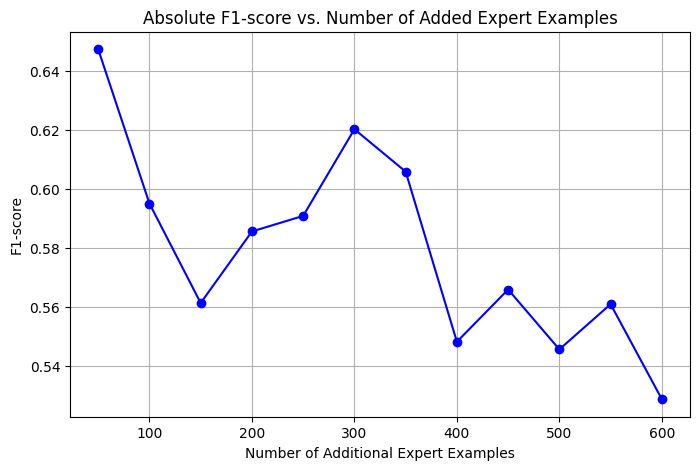

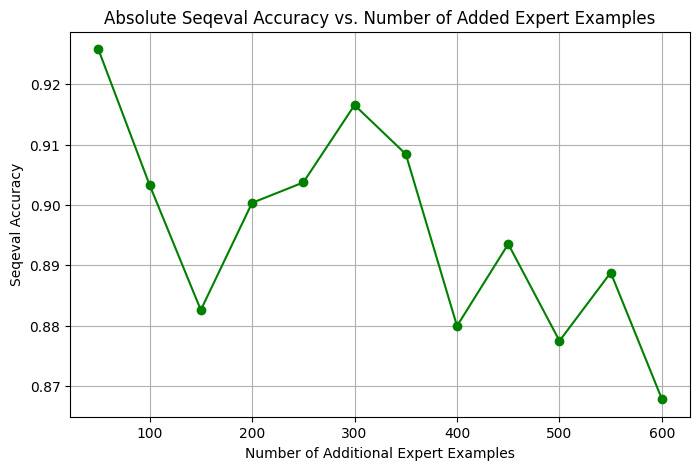

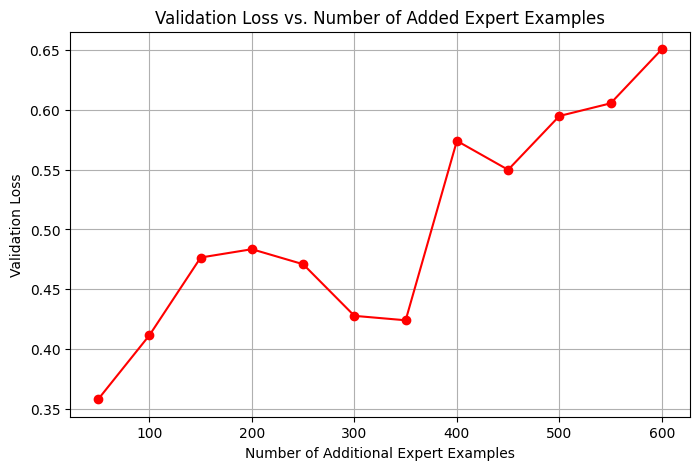

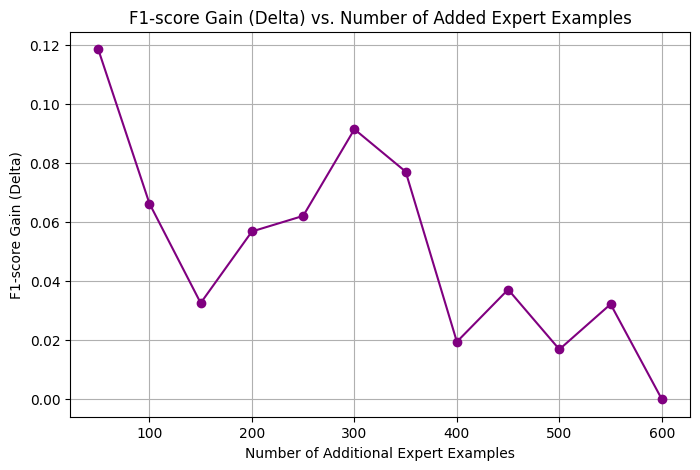

In [ ]:
baseline_f1 = evaluate_entity_level(model_init_12, eval_iter)[2]
plot_all_metrics(active_history, baseline_f1)

In [ ]:
active_history_no_overfit = active_learning_loop_no_overfit(model_init_12, combined_dataset, train, eval_iter, fine_tune_epochs=2, batch_to_add=50)

Evaluating: 100%|██████████| 102/102 [00:21<00:00,  4.74it/s]


Validation loss: 0.3786753573107953
Seqeval accuracy: 0.9263575754491322
F1-Score: 0.6345609065155807
Classification report:
              precision    recall  f1-score   support

         LOC       0.49      0.87      0.63      1089
        MISC       0.26      0.35      0.30       693
         ORG       0.45      0.54      0.49       824
         PER       0.86      0.95      0.90      1455

   micro avg       0.55      0.74      0.63      4061
   macro avg       0.52      0.68      0.58      4061
weighted avg       0.58      0.74      0.64      4061



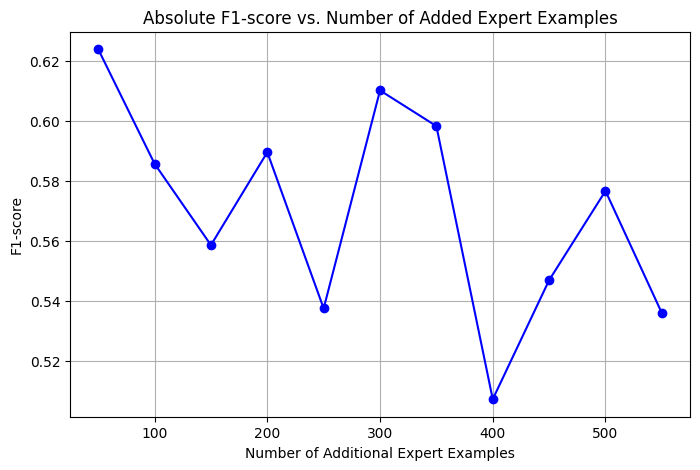

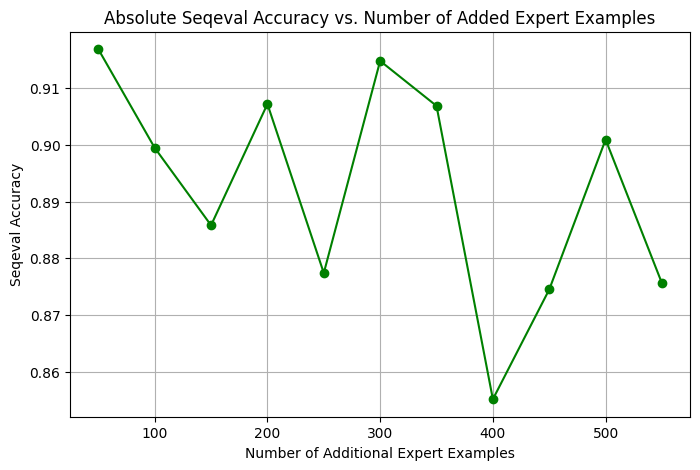

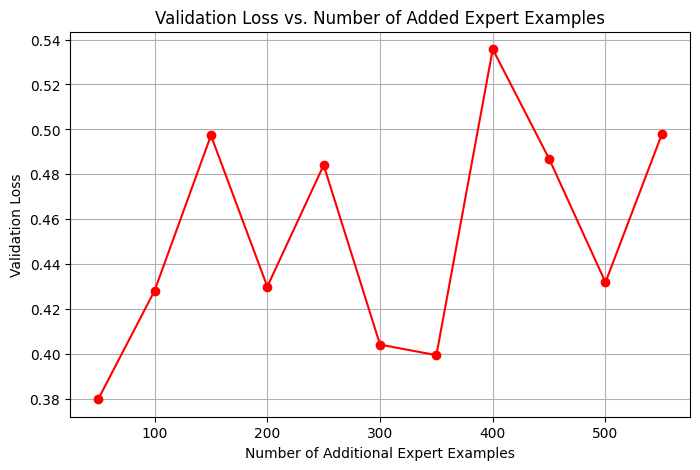

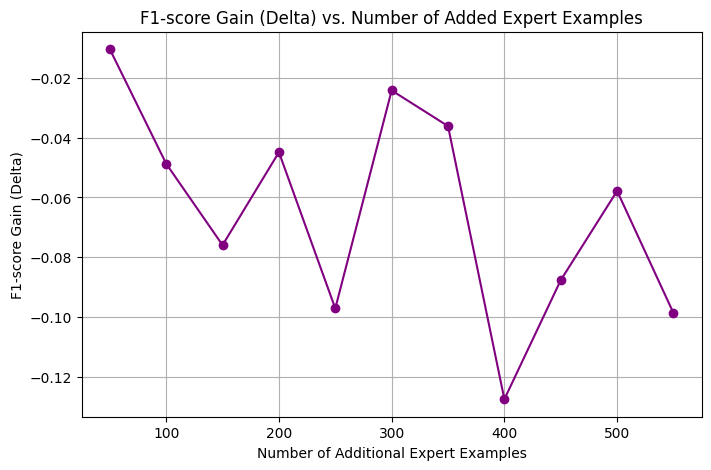

In [ ]:
baseline_f1 = evaluate_entity_level(model_init_12, eval_iter)[2]
plot_all_metrics(active_history_no_overfit, baseline_f1)

In [ ]:
preliminary_threshold_experiment_kfold = [(0.01,20,np.float64(0.5016378211731379),np.float64(0.8655860349127181),np.float64(0.5066531460001772)),(0.02,40,np.float64(0.5154634525244661),np.float64(0.8750877907272635),np.float64(0.4848787621868884)),(0.03,61,np.float64(0.5395605647516192),np.float64(0.8896890426993741),np.float64(0.44753564853294225)),(0.05,101,np.float64(0.5321475900607713),np.float64(0.8846353503995115),np.float64(0.4690778586356079)),(0.07,142,np.float64(0.6093204853231352),np.float64(0.9160720647361188),np.float64(0.3843227606120647)),(0.1,203,np.float64(0.5914504205309717),np.float64(0.9083821059595909),np.float64(0.4124917702201535)),(0.12,244,np.float64(0.6390681430721176),np.float64(0.9265560588325105),np.float64(0.35206035241922906)),(0.15,305,np.float64(0.6413605960905506),np.float64(0.9304544760547611),np.float64(0.35835986465361774)),(0.2,407,np.float64(0.6417390655665456),np.float64(0.9272787419207085),np.float64(0.35387016284261263))]

In [ ]:
active_history = [(50, np.float64(0.6474924722251064), 0.925797750521655, 0.35778143483341907), (100, np.float64(0.5951690821256038), 0.9033029670721157, 0.41138715530727427), (150, np.float64(0.5614358030372757), 0.8825639981678457, 0.4764732987272973), (200, np.float64(0.5856978527607362), 0.9003257163214413, 0.4834309658035636), (250, np.float64(0.5909800859039438), 0.9037101124739172, 0.4708415176719427), (300, np.float64(0.6203638556638857), 0.9165351926306682, 0.42761496925616965), (350, np.float64(0.6059884989093793), 0.9084177311822484, 0.42390663560260744), (400, np.float64(0.5482939158692904), 0.8799175530561352, 0.5741837498019723), (450, np.float64(0.5660199660953099), 0.8935060308412642, 0.5499503851375159), (500, np.float64(0.5457171224839787), 0.8774492340577129, 0.5950004141047305), (550, np.float64(0.5610481323174131), 0.8887729655453204, 0.6056150352837992), (600, np.float64(0.5288200822181406), 0.8677795307649244, 0.650935581940062)]

In [ ]:
active_history_no_overfit = [(50, np.float64(0.6240570846075433), 0.9168151050944069, 0.3799415262160348), (100, np.float64(0.5858062037837319), 0.8994605323426128, 0.4282226888280289), (150, np.float64(0.5586232284189214), 0.8858211613822586, 0.4973258347634007), (200, np.float64(0.5896507874400861), 0.907170848389231, 0.43003977177774205), (250, np.float64(0.5374686267479384), 0.8774237874701003, 0.48412608022929404), (300, np.float64(0.6102911846828879), 0.9147539314977862, 0.40425217115119394), (350, np.float64(0.5983743022230927), 0.9068400427502672, 0.3995421032841299), (400, np.float64(0.5071452875127594), 0.8552089164842994, 0.5356959918623462), (450, np.float64(0.5469083155650319), 0.8745228764822637, 0.48694484633411844), (500, np.float64(0.5767190664480663), 0.9009109878365311, 0.4319597992534731), (550, np.float64(0.5359268141042722), 0.8756170797496056, 0.4978929065971398)]